<p style="font-size:50px;color:gold">
<b>Intro to Data Science Project</b>
</p>

**_Juan Esteban Alarcón Bravo_**

<br/>

Analyzing organ donation data from Bogotá, Colombia, from 2015 to 2024.

<br/>

**Table of Contents**

1. [Imports and Cleanup](#1-imports-and-cleanup)
    - [Libraries](#11-libraries)
    - [Data](#12-data)
99. [Exhibits](#x-exhibits)

<br/>

# **1 - Imports and Cleanup**

To begin, we need to import and setup the necessary libraries, load the dataset, and perform some data cleaning.

## 1.1 - Libraries

In [250]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------------------------

# Set pandas display options
pd.set_option('display.width', 1000)

# Define custom colormap based on Set2
colors = plt.colormaps['Set2'].colors
colors_ext = plt.colormaps['tab20'].colors

# Set default colormap for Matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

## 1.2 - Data

Here, we address the problem of data cleanup, setup, and general preprocessing.

### *1.2.1 - Import*

First, we **import** the data from the CSV file into a pandas `DataFrame` and check the first rows, null values and the column names & data types.

In [251]:
# URL RAW del dataset
data_url = "https://raw.githubusercontent.com/jalarconb/DataScience2024II/main/data/raw_trasplantes.csv"

# Cargar el dataset desde GitHub
df = pd.read_csv(data_url, encoding='latin1', delimiter=';', dtype=object)

# Mostrar las primeras filas para verificar
df.head()

,Año,Proceso,Órgano,Sexo,Grupo de edad,Cantidad,Tipo de donante
0,2015,Donación,Riñón,Hombre,No aplica,39,Donante vivo
1,2015,Donación,Riñón,Mujer,No aplica,32,Donante vivo
2,2015,Donación,Riñón,Hombre,No aplica,70,Donante cadaverico
3,2015,Donación,Riñón,Mujer,No aplica,48,Donante cadaverico
4,2015,Donación,Corazón,Hombre,No aplica,0,Donante vivo


In [252]:
# Display the data types and check for missing values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Año              2120 non-null   object
 1   Proceso          2120 non-null   object
 2   Órgano           2120 non-null   object
 3   Sexo             2120 non-null   object
 4   Grupo de edad    2120 non-null   object
 5   Cantidad         2120 non-null   object
 6   Tipo de donante  2120 non-null   object
dtypes: object(7)
memory usage: 116.1+ KB


,0
Año,0
Proceso,0
Órgano,0
Sexo,0
Grupo de edad,0
Cantidad,0
Tipo de donante,0


As there are no null values in the dataset, we do not need to worry about dealing with them. Also, all the columns but `Cantidad` _(Quantity)_ are categorical; our next step is going to be **text standardization** for those categorical columns.

- **Strip** spaces and put the text in **title case**.
- Check the **unique values** in each column to make sure that there are no duplicates or incorrect values (due to typos, etc.).

In [253]:
# Standardize text in categorical columns (Strip + TitleCase)
df['Año'] = df['Año'].str.strip().str.title()
df['Proceso'] = df['Proceso'].str.strip().str.title()
df['Órgano'] = df['Órgano'].str.strip().str.title()
df['Sexo'] = df['Sexo'].str.strip().str.title()
df['Grupo de edad'] = df['Grupo de edad'].str.strip().str.title()
df['Tipo de donante'] = df['Tipo de donante'].str.strip().str.title()

# Check for unique values in each column
print("Unique values in 'Año':", df['Año'].unique(), "\n")
print("Unique values in 'Proceso':", df['Proceso'].unique(), "\n")
print("Unique values in 'Órgano':", df['Órgano'].unique(), "\n")
print("Unique values in 'Sexo':", df['Sexo'].unique(), "\n")
print("Unique values in 'Grupo de edad':", df['Grupo de edad'].unique(), "\n")
print("Unique values in 'Tipo de donante':", df['Tipo de donante'].unique(), "\n")

Unique values in 'Año': ['2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023'
 '2024 Ii Trim'] 

Unique values in 'Proceso': ['Donación' 'Lista De Espera De Donación De Órganos' 'Trasplantes'
 'Donación Personas'] 

Unique values in 'Órgano': ['Riñón' 'Corazón' 'Hígado' 'Pulmón' 'Combinado Riñón-Hígado'
 'Tejidos (Córneas)' 'No Aplica' 'Combinado Corazón -Riñón' 'Páncreas'
 'Combinado \nRiñón-Páncreas' 'Combinado Riñón-Pancreas'] 

Unique values in 'Sexo': ['Hombre' 'Mujer' 'No Aplica'] 

Unique values in 'Grupo de edad': ['No Aplica' '0-9 Años' '10-19 Años' '20-29 Años' '30-39 Años'
 '40-49 Años' '50-59 Años' '60-69 Años' '> 70  Años'] 

Unique values in 'Tipo de donante': ['Donante Vivo' 'Donante Cadaverico' 'No Aplica' 'Donante Cadavérico'] 



### *1.2.2 - Cleanup & Preprocessing*

Some values require attention. In `Año` (_"Year"_), for instance, the year _2024_ includes not only the year itself but also an indication of the trimester (_"2024 Ii Trim"_). This shows a clear bias in the data, as the year 2024 contains fewer observations compared to other years, which represent complete annual data.

<div class="alert alert-block alert-info">
<b>Note:</b> This particular year-bias is going to be important for some of the next steps of the project but, for the time being, we are going to change all the occurrences to "2024".
</div>

As for the other columns, there are some missing and extra characters and accents; we can work on that.

Also, the `Tipo de Donante` (Donor Type) column can be changed; we can rename it as `Donante_Vivo` to check whether the donor is alive or not (`1` or `0`, respectively). As for the "No Aplica" (Does not apply) values, we will assign `-1`:

In [254]:
# Rename columns

df.rename(columns={'Tipo de donante': 'Donante_Vivo', 'Grupo de edad':'Grupo_Edad'}, inplace=True)

# Cleanup: 'Año' (Year)
df['Año'] = df['Año'].replace({
    '2024 Ii Trim': '2024'
})

# Cleanup: 'Proceso' (Process)
df['Proceso'] = df['Proceso'].replace({
    'Lista De Espera De Donación De Órganos': 'Lista de Espera',
    'Trasplantes': 'Trasplante',
})

# Cleanup: 'Órgano' (Organ)
df['Órgano'] = df['Órgano'].replace({
    'No Aplica': 'NA',
    'Combinado Corazón -Riñón': 'Combinado Corazón-Riñón',
    'Combinado \nRiñón-Páncreas': 'Combinado Riñón-Páncreas',
    'Combinado Riñón-Pancreas': 'Combinado Riñón-Páncreas',
    'Tejidos (Córneas)': 'Córneas'
})

# Cleanup: 'Grupo_Edad' (Age Group)
df['Grupo_Edad'] = df['Grupo_Edad'].replace({
    'No Aplica': 'NA',
    '> 70  Años': '> 70 Años'
})

# Cleanup: 'Donante_Vivo' (Is Donor Alive?)
df['Donante_Vivo'] = df['Donante_Vivo'].replace({
    'No Aplica': '-1',
    'Donante Vivo': '1',
    'Donante Cadaverico': '0',
    'Donante Cadavérico': '0',
})

print(df.head())

    Año   Proceso   Órgano    Sexo Grupo_Edad Cantidad Donante_Vivo
0  2015  Donación    Riñón  Hombre         NA       39            1
1  2015  Donación    Riñón   Mujer         NA       32            1
2  2015  Donación    Riñón  Hombre         NA       70            0
3  2015  Donación    Riñón   Mujer         NA       48            0
4  2015  Donación  Corazón  Hombre         NA        0            1


In [255]:
# Check unique values in each modified column
print("Unique values in 'Año':", df['Año'].unique(), "\n")
print("Unique values in 'Proceso':", df['Proceso'].unique(), "\n")
print("Unique values in 'Órgano':", df['Órgano'].unique(), "\n")
print("Unique values in 'Grupo_Edad':", df['Grupo_Edad'].unique(), "\n")
print("Unique values in 'Donante_Vivo':", df['Donante_Vivo'].unique(), "\n")

Unique values in 'Año': ['2015' '2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023' '2024'] 

Unique values in 'Proceso': ['Donación' 'Lista de Espera' 'Trasplante' 'Donación Personas'] 

Unique values in 'Órgano': ['Riñón' 'Corazón' 'Hígado' 'Pulmón' 'Combinado Riñón-Hígado' 'Córneas'
 'NA' 'Combinado Corazón-Riñón' 'Páncreas' 'Combinado Riñón-Páncreas'] 

Unique values in 'Grupo_Edad': ['NA' '0-9 Años' '10-19 Años' '20-29 Años' '30-39 Años' '40-49 Años'
 '50-59 Años' '60-69 Años' '> 70 Años'] 

Unique values in 'Donante_Vivo': ['1' '0' '-1'] 



We should also change the data type of `Año`, `Cantidad` and `Donante_Vivo` to numeric.

In [256]:
#  Change 'Año' to numeric
df['Año'] = pd.to_numeric(df['Año'], errors='coerce')

#  Change 'Cantidad' to numeric
df['Cantidad'] = pd.to_numeric(df['Cantidad'], errors='coerce')

#  Change 'Donante_Vivo' to numeric
df['Donante_Vivo'] = pd.to_numeric(df['Donante_Vivo'], errors='coerce')

# Check for null values
df.isnull().sum()

,0
Año,0
Proceso,0
Órgano,0
Sexo,0
Grupo_Edad,0
Cantidad,0
Donante_Vivo,0


### _1.2.3 - DataFrame Separation_

We will work with two subsets of the main dataframe (`df`):

- One with only the transplant rows (`df_trasplantes`)
- The other with only the donation rows (`df_donaciones`).

In [257]:
# Filtered DF: Process is a Transplant
df_trasplantes = df[df['Proceso'] == 'Trasplante']
df_trasplantes.head()

,Año,Proceso,Órgano,Sexo,Grupo_Edad,Cantidad,Donante_Vivo
864,2015,Trasplante,Riñón,Hombre,0-9 Años,4,-1
865,2015,Trasplante,Riñón,Hombre,10-19 Años,12,-1
866,2015,Trasplante,Riñón,Hombre,20-29 Años,16,-1
867,2015,Trasplante,Riñón,Hombre,30-39 Años,30,-1
868,2015,Trasplante,Riñón,Hombre,40-49 Años,26,-1


In [258]:
# Filtered DF: Process is a Donation
df_donaciones = df[df['Proceso'] == 'Donación']
df_donaciones.head()

,Año,Proceso,Órgano,Sexo,Grupo_Edad,Cantidad,Donante_Vivo
0,2015,Donación,Riñón,Hombre,NA,39,1
1,2015,Donación,Riñón,Mujer,NA,32,1
2,2015,Donación,Riñón,Hombre,NA,70,0
3,2015,Donación,Riñón,Mujer,NA,48,0
4,2015,Donación,Corazón,Hombre,NA,0,1


<br/>

# **2 - Data Analysis**

## 2.1 - Exploration: Transplants

We will start with a statistical exploration of the transplants dataset (`df_trasplantes`). This includes performing correlation tests to uncover potential hidden relationships and identify opportunities for data mining.

The `Órgano` column presents a unique case: some rows refer to multi-organ transplants (two organs). This requires an additional consideration for two key reasons. First, these rows contain valuable data about the transplants of both organs involved. Second, we can conduct a separate analysis focusing on these combined rows later.

The approach that we will follow in order to address this problem is:

- **Add a new column** (`Combinado`) to mark the multi-organ rows.
- **Split** each multi-organ row into two separate rows, assigning one organ to each row while retaining all other relevant information.

In [259]:
# Unique Values: Organs
df['Órgano'].unique()

array(['Riñón', 'Corazón', 'Hígado', 'Pulmón', 'Combinado Riñón-Hígado',
       'Córneas', 'NA', 'Combinado Corazón-Riñón', 'Páncreas',
       'Combinado Riñón-Páncreas'], dtype=object)

In [260]:
# Step 1 - Add "Combinado" Column: 1 if combined, 0 else
df_trasplantes.loc[:, 'Combinado'] = df_trasplantes['Órgano'].apply(lambda x: 1 if 'Combinado' in x else 0)
df_trasplantes.head()

<ipython-input-260-8c56d31d0f04>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trasplantes.loc[:, 'Combinado'] = df_trasplantes['Órgano'].apply(lambda x: 1 if 'Combinado' in x else 0)


,Año,Proceso,Órgano,Sexo,Grupo_Edad,Cantidad,Donante_Vivo,Combinado
864,2015,Trasplante,Riñón,Hombre,0-9 Años,4,-1,0
865,2015,Trasplante,Riñón,Hombre,10-19 Años,12,-1,0
866,2015,Trasplante,Riñón,Hombre,20-29 Años,16,-1,0
867,2015,Trasplante,Riñón,Hombre,30-39 Años,30,-1,0
868,2015,Trasplante,Riñón,Hombre,40-49 Años,26,-1,0


In [261]:
# Step 2 - Split the combined rows
def split_combined(row):
    if row['Combinado'] == 1:
        # Split organs using "-", remove "Combinado" keyword
        organs = [org.replace('Combinado ', '') for org in row['Órgano'].split('-')]
        return pd.DataFrame({
            'Órgano': organs,
            'Combinado': [1] * len(organs),
            'Sexo': [row['Sexo']] * len(organs),
            'Grupo_Edad': [row['Grupo_Edad']] * len(organs),
            'Cantidad': [row['Cantidad']] * len(organs),
            'Donante_Vivo': [row['Donante_Vivo']] * len(organs),
            'Año': [row['Año']] * len(organs),
            'Proceso': [row['Proceso']] * len(organs)
        })
    else:
        # Keep the rest without changes
        return pd.DataFrame([row])

# Apply to each row and concat result
df_trasplantes = pd.concat(df_trasplantes.apply(split_combined, axis=1).tolist(), ignore_index=True)

# Print results
print(df_trasplantes.head())

print("\nUnique values for [Órgano]:\n",df_trasplantes['Órgano'].unique())

    Año     Proceso Órgano    Sexo  Grupo_Edad  Cantidad  Donante_Vivo  Combinado
0  2015  Trasplante  Riñón  Hombre    0-9 Años         4            -1          0
1  2015  Trasplante  Riñón  Hombre  10-19 Años        12            -1          0
2  2015  Trasplante  Riñón  Hombre  20-29 Años        16            -1          0
3  2015  Trasplante  Riñón  Hombre  30-39 Años        30            -1          0
4  2015  Trasplante  Riñón  Hombre  40-49 Años        26            -1          0

Unique values for [Órgano]:
 ['Riñón' 'Corazón' 'Hígado' 'Pulmón' 'Córneas' 'Páncreas']


### _2.1.1 Correlation: Sex vs. Organ_

Since we are working with **categorical variables** (sex and organ), directly applying a standard correlation measure (Spearman, etc.) would not be appropriate in this case. After some research, I found a more advanced methods that we could consider, *Cramér's V.*

**Cramér's V** is a measure of association between two categorical variables based on the Chi-squared statistic. It handles categorical variables without requiring numerical transformations.

**Step 1: Build a contingency table**

We'll start by creating a contingency table where each cell represents the sum of `Cantidad` for a combination of `Órgano` and `Sexo`.

In [262]:
# Contingency table
contingency_table = df_trasplantes.pivot_table(
    values='Cantidad',
    index='Órgano',
    columns='Sexo',
    aggfunc='sum',
    fill_value=0
)

print("Contingency Table (Sum of 'Cantidad'):")
print(contingency_table)

Contingency Table (Sum of 'Cantidad'):
Sexo      Hombre  Mujer
Órgano                 
Corazón      139     55
Córneas     3582   2930
Hígado       552    586
Pulmón        64     53
Páncreas       1      0
Riñón       1673   1127


**Step 2: Compute Chi-squared statistic and Cramér's V**

We use the contingency table to calculate the Chi-squared statistic and then Cramér's V:

In [263]:
from scipy.stats import chi2_contingency

# Chi-squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Total number of observations
n = contingency_table.sum().sum()

# Calculate Cramér's V
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("\nExpected frequencies:\n", expected)
print("\nCramér's V:", cramers_v)

Chi-squared statistic: 64.53682113431675
p-value: 1.3981859957982608e-12
Degrees of Freedom: 5

Expected frequencies:
 [[1.08356625e+02 8.56433748e+01]
 [3.63720795e+03 2.87479205e+03]
 [6.35617729e+02 5.02382271e+02]
 [6.53490987e+01 5.16509013e+01]
 [5.58539305e-01 4.41460695e-01]
 [1.56391005e+03 1.23608995e+03]]

Cramér's V: 0.0774385640122251


**Explanation of the results:**

- **Chi-squared statistic:** Indicates how far the observed data is from what would be expected if there were no relationship between Órgano and Sexo.

- **p-value:** Tests the null hypothesis that Órgano and Sexo are independent: Since we have a small p-value (< 0.05), we are rejecting the null hypothesis, meaning there’s likely an association.

- **Cramér's V:** A value of  less than 0.1 means that there is little to no association, like in this case. `0.077` indicates a very weak association, even though it’s statistically significant.

And, since this relationship is not really meaningfull, we **will not keep on exploring** this path.

### _2.1.1 Other Correlations_

I also explored other pairs of variables with the hope of finding higher Cramér's V values. Such results are as follow:

**Try 2: Organ vs. Age Group**

In [264]:
# Contingency table
contingency_table = df_trasplantes.pivot_table(
    values='Cantidad',
    index='Sexo',
    columns='Grupo_Edad',
    aggfunc='sum',
    fill_value=0
)

# Chi-squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Total number of observations
n = contingency_table.sum().sum()

# Calculate Cramér's V
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("TRANSPLANT CORRELATION\nOrgan vs. Age Group\n")
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Cramér's V:", cramers_v)

print("\nNOT A MEANINGFUL CORRELATION")

TRANSPLANT CORRELATION
Organ vs. Age Group

Chi-squared statistic: 140.25616878180708
p-value: 4.492087099018914e-27
Cramér's V: 0.11416013980026661

NOT A MEANINGFUL CORRELATION


In [265]:
# Contingency table
contingency_table = df_trasplantes.pivot_table(
    values='Cantidad',
    index='Grupo_Edad',
    columns='Año',
    aggfunc='sum',
    fill_value=0
)

# Chi-squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Total number of observations
n = contingency_table.sum().sum()

# Calculate Cramér's V
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print("TRANSPLANT CORRELATION\nOrgan vs. Age Group\n")
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Cramér's V:", cramers_v)

print("\nNOT A MEANINGFUL CORRELATION")

TRANSPLANT CORRELATION
Organ vs. Age Group

Chi-squared statistic: 409.11703518789164
p-value: 3.4946336422663936e-52
Cramér's V: 0.07369334464449262

NOT A MEANINGFUL CORRELATION


## 2.2 - Clustering

Trying to cluster Age Group vs. Organ for Donations

### Cantidad log-transform

The `Cantidad` column represent a wide range of numerical values, so we start by doing some **descriptive statistics** to get a better understanding of the data.

In [266]:
# Statistical description of the Cantidad column
print("Descriptive statistics for Cantidad:")
print(df_donaciones['Cantidad'].describe())

# Print the Median
print(f"\nMedian: {df_donaciones['Cantidad'].median()}")

# Calculate the IQR and the limits
q1 = df_donaciones['Cantidad'].quantile(0.25)
q3 = df_donaciones['Cantidad'].quantile(0.75)
iqr = q3 - q1

lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

print(f"IQR:{iqr}\nLower limit: {lower_limit}\nUpper limit: {upper_limit}")

Descriptive statistics for Cantidad:
count    212.000000
mean      17.537736
std       24.872252
min        0.000000
25%        0.000000
50%        6.000000
75%       26.250000
max      148.000000
Name: Cantidad, dtype: float64

Median: 6.0
IQR:26.25
Lower limit: -39.375
Upper limit: 65.625


Some observations:
- The `mean` (_~11_) is significantly lower than the `max` (_203_). This hints that the distribution is **right skewed**.
- Also, the `median` (_1_) is smaller than the `mean` (_11_), further supporting this hypothesis.

With that in mind, we now check the IQR and limits, and their relationship with the actual data:
- First, while the `lower limit` is _-13.5_, the `min` is _0_. Thus, there are **no negative outliers** in the data.
- On the other hand, the `upper limit` is _22.5_, so every value above that should be considered an outlier.

Visualizing the data, we can notice the big tail of the distribution (skewness) in the histogram, and the outliers in the boxplot:

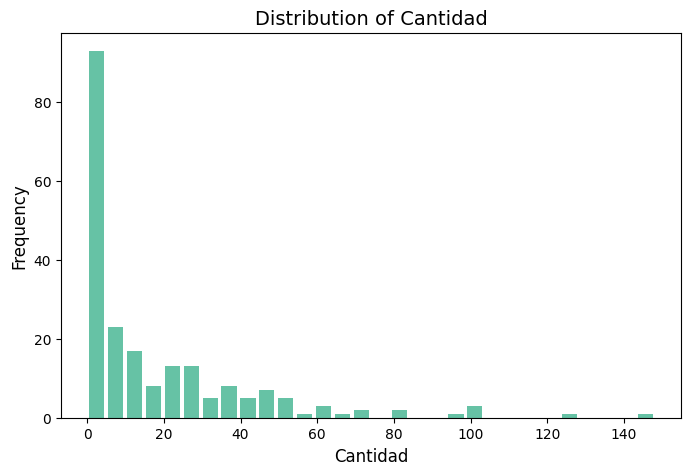

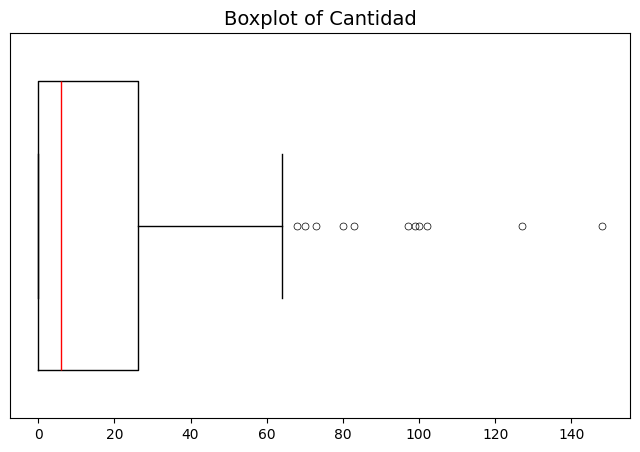

In [267]:
# Histogram: Cantidad
plt.figure(figsize=(8, 5))
plt.hist(df_donaciones['Cantidad'], bins=30, rwidth=0.8)
plt.title('Distribution of Cantidad', fontsize=14)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Boxplot: Cantidad
plt.figure(figsize=(8, 5))
medianprops = dict(linestyle='-', color='red')
flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markeredgewidth=0.5)
plt.boxplot(df_donaciones['Cantidad'], vert=False, medianprops=medianprops, flierprops=flierprops, widths=(0.75))
plt.title('Boxplot of Cantidad', fontsize=14)
plt.yticks([])  # Remove y-axis labels
plt.show()

To address this skewness, we will aply a <span style="color:teal">**log transformation**</span> to the data and then generate the statistical summary and plots again.

<div class="alert alert-block alert-success">
  <span>✅</span> One of the most important advantages of this technique compared to other alternatives (such as <em>min-max</em> or <em>z-score</em>) is the <strong>reduction of the asymmetry</strong> of the distribution, a very valuable point when dealing with extreme outliers that we are not removing.
</div>

<ipython-input-268-c2482f64fa56>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_donaciones.loc[:, 'Cantidad_log'] = np.log1p(df_donaciones['Cantidad'])  # .loc to get rid of a Warning


Descriptive statistics for Cantidad_log:
count    212.000000
mean       1.883169
std        1.595508
min        0.000000
25%        0.000000
50%        1.945910
75%        3.304929
max        5.003946
Name: Cantidad_log, dtype: float64

Median: 1.9459101490553132
IQR: 3.304928777047048
Lower limit: -4.957393165570572
Upper limit: 8.26232194261762



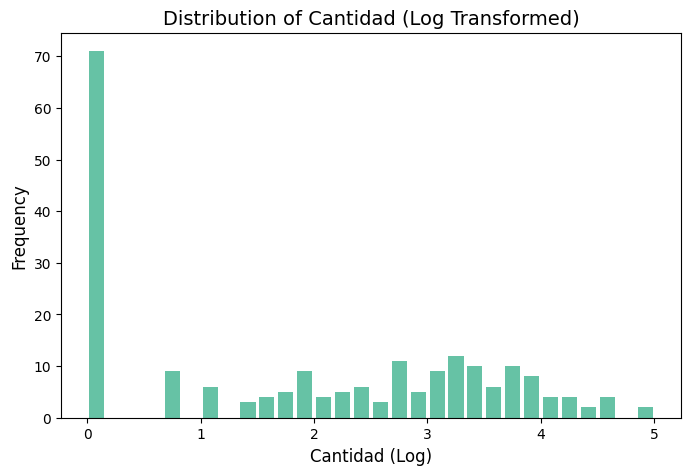

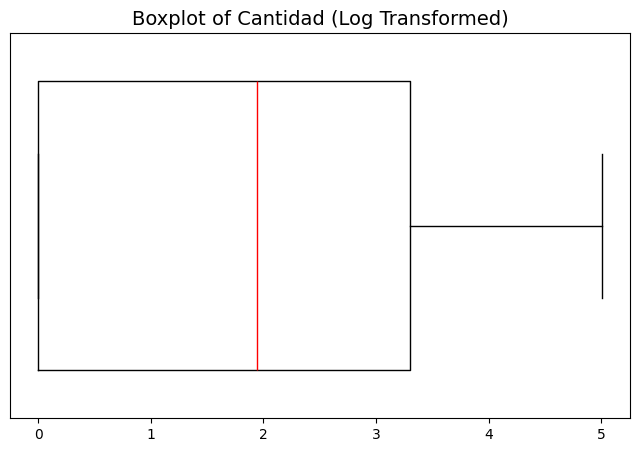

In [268]:
# Apply log transformation to 'Cantidad'
df_donaciones.loc[:, 'Cantidad_log'] = np.log1p(df_donaciones['Cantidad'])  # .loc to get rid of a Warning

# Descriptive statistics
print("Descriptive statistics for Cantidad_log:")
print(df_donaciones['Cantidad_log'].describe())

# The median
print(f"\nMedian: {df_donaciones['Cantidad_log'].median()}")

# Calculate the IQR and the limits for the log-transformed column
q1_log = df_donaciones['Cantidad_log'].quantile(0.25)
q3_log = df_donaciones['Cantidad_log'].quantile(0.75)
iqr_log = q3_log - q1_log

lower_limit_log = q1_log - 1.5 * iqr_log
upper_limit_log = q3_log + 1.5 * iqr_log

print(f"IQR: {iqr_log}\nLower limit: {lower_limit_log}\nUpper limit: {upper_limit_log}\n")


# Then, we plot again...

# Histogram: Cantidad (log-transformed)
plt.figure(figsize=(8, 5))
plt.hist(df_donaciones['Cantidad_log'], bins=30, rwidth=0.8)
plt.title('Distribution of Cantidad (Log Transformed)', fontsize=14)
plt.xlabel('Cantidad (Log)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Boxplot: Cantidad (log-transformed)
plt.figure(figsize=(8, 5))
medianprops = dict(linestyle='-', color='red')
flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markeredgewidth=0.5)
plt.boxplot(df_donaciones['Cantidad_log'], vert=False, medianprops=medianprops, flierprops=flierprops, widths=(0.75))
plt.title('Boxplot of Cantidad (Log Transformed)', fontsize=14)
plt.yticks([])  # Remove y-axis labels
plt.show()

### Cluster: Alive Status vs. Organ for Donations

In [291]:
print(df_donaciones.head())
print(df_donaciones['Donante_Vivo'].unique())

    Año   Proceso   Órgano    Sexo Grupo_Edad  Cantidad  Donante_Vivo  Cantidad_log
0  2015  Donación    Riñón  Hombre         NA        39             1      3.688879
1  2015  Donación    Riñón   Mujer         NA        32             1      3.496508
2  2015  Donación    Riñón  Hombre         NA        70             0      4.262680
3  2015  Donación    Riñón   Mujer         NA        48             0      3.891820
4  2015  Donación  Corazón  Hombre         NA         0             1      0.000000
[1 0]


In [270]:
df_num = df_donaciones[['Donante_Vivo', 'Órgano']]

In [271]:
from sklearn.preprocessing import OneHotEncoder

# Select the Órgano column for one-hot encoding
organo_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use drop='first' to reduce dimensionality

# Apply one-hot encoding to the Órgano column
organo_encoded = organo_encoder.fit_transform(df_num[['Órgano']])

# Convert to DataFrame with proper column names
organo_encoded_df = pd.DataFrame(organo_encoded, columns=organo_encoder.get_feature_names_out(['Órgano']))

# Combine with the Donante_Vivo column
df_encoded = pd.concat([df_num[['Donante_Vivo']].reset_index(drop=True), organo_encoded_df], axis=1)

# Display the first few rows
print(df_encoded.head())


   Donante_Vivo  Órgano_Corazón  Órgano_Córneas  Órgano_Hígado  Órgano_Pulmón  Órgano_Páncreas  Órgano_Riñón
0             1             0.0             0.0            0.0            0.0              0.0           1.0
1             1             0.0             0.0            0.0            0.0              0.0           1.0
2             0             0.0             0.0            0.0            0.0              0.0           1.0
3             0             0.0             0.0            0.0            0.0              0.0           1.0
4             1             1.0             0.0            0.0            0.0              0.0           0.0


In [272]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=2, random_state=42)
k_means.fit(df_encoded)

# Add cluster labels to the DataFrame for analysis
# df_encoded['Cluster'] = k_means.labels_

# Display cluster assignments
print(df_encoded.head())

   Donante_Vivo  Órgano_Corazón  Órgano_Córneas  Órgano_Hígado  Órgano_Pulmón  Órgano_Páncreas  Órgano_Riñón
0             1             0.0             0.0            0.0            0.0              0.0           1.0
1             1             0.0             0.0            0.0            0.0              0.0           1.0
2             0             0.0             0.0            0.0            0.0              0.0           1.0
3             0             0.0             0.0            0.0            0.0              0.0           1.0
4             1             1.0             0.0            0.0            0.0              0.0           0.0


In [273]:
k_means.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [274]:
np.unique(k_means.labels_)

array([0, 1], dtype=int32)

In [275]:
centers = k_means.cluster_centers_
centers

array([[ 5.00000000e-01, -1.66533454e-16, -4.16333634e-17,
        -1.66533454e-16,  1.00000000e+00,  0.00000000e+00,
        -1.66533454e-16],
       [ 5.00000000e-01,  2.32558140e-01,  1.39534884e-01,
         2.32558140e-01, -3.05311332e-16,  2.32558140e-02,
         2.32558140e-01]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


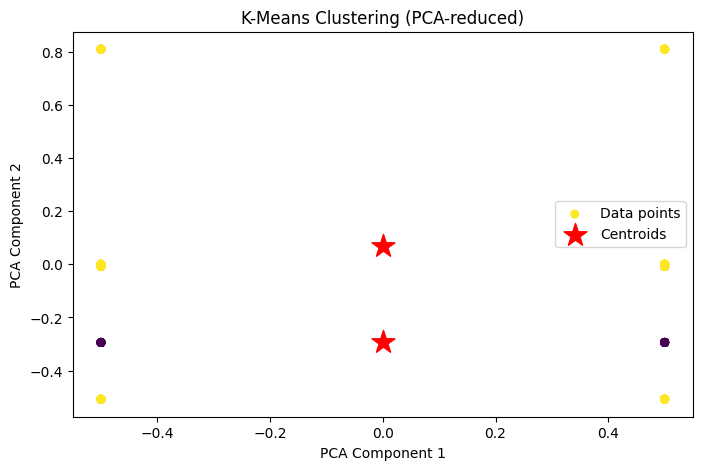

In [276]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_encoded)

# Extract cluster centroids in PCA-reduced space
centers_pca = pca.transform(centers)

# Plot the clusters
plt.figure(figsize=(8, 5))

# Scatter plot of the PCA-transformed data points
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=k_means.labels_, cmap='viridis', s=30, label='Data points')

# Scatter plot of centroids
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], color='red', marker='*', s=300, label='Centroids')

# Labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering (PCA-reduced)')
plt.legend()
plt.show()

In [278]:
from sklearn import metrics

score = metrics.silhouette_score (df_encoded, k_means.labels_)
print("Silhouette Score = ", score)

Silhouette Score =  0.25393132472064617


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Text(0.5, 1.0, 'Elbow Plot: Optimal K')

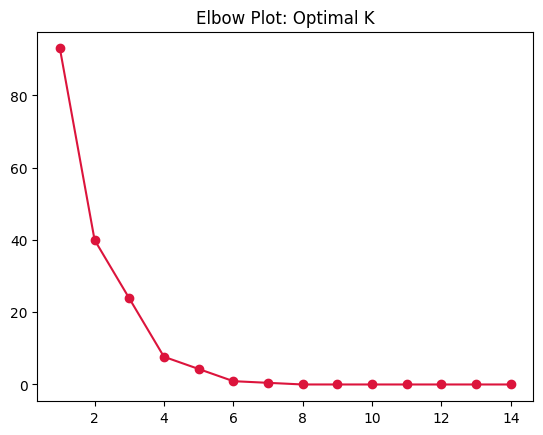

In [279]:
wscc = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, init="k-means++",random_state=0)
    kmeans.fit(df_pca)
    wscc.append(kmeans.inertia_)

# Elbowplot: Optimal K
plt.plot(range(1,15),wscc,marker="o",c="crimson")
plt.title("Elbow Plot: Optimal K")

In [286]:
k_means = KMeans(n_clusters=4, random_state=42)
k_means.fit(df_encoded)

# Add cluster labels to the DataFrame for analysis
# df_encoded['Cluster'] = k_means.labels_

# Display cluster assignments
print(df_encoded.head())

   Donante_Vivo  Órgano_Corazón  Órgano_Córneas  Órgano_Hígado  Órgano_Pulmón  Órgano_Páncreas  Órgano_Riñón
0             1             0.0             0.0            0.0            0.0              0.0           1.0
1             1             0.0             0.0            0.0            0.0              0.0           1.0
2             0             0.0             0.0            0.0            0.0              0.0           1.0
3             0             0.0             0.0            0.0            0.0              0.0           1.0
4             1             1.0             0.0            0.0            0.0              0.0           0.0


In [287]:
np.unique(k_means.labels_)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [288]:
centers = k_means.cluster_centers_
centers

array([[ 5.00000000e-01, -1.66533454e-16, -4.16333634e-17,
        -1.66533454e-16,  1.00000000e+00,  0.00000000e+00,
        -1.66533454e-16],
       [ 1.00000000e+00,  4.34782609e-01,  2.60869565e-01,
        -1.94289029e-16, -1.94289029e-16,  4.34782609e-02,
        -1.94289029e-16],
       [ 0.00000000e+00,  2.77555756e-17,  0.00000000e+00,
         1.00000000e+00,  2.77555756e-17,  0.00000000e+00,
         2.77555756e-17],
       [ 0.00000000e+00,  4.34782609e-01,  2.60869565e-01,
        -1.94289029e-16, -1.94289029e-16,  4.34782609e-02,
        -1.94289029e-16],
       [ 5.00000000e-01, -1.66533454e-16, -4.16333634e-17,
        -1.66533454e-16, -1.66533454e-16,  0.00000000e+00,
         1.00000000e+00],
       [ 1.00000000e+00,  2.77555756e-17,  0.00000000e+00,
         1.00000000e+00,  2.77555756e-17,  0.00000000e+00,
         2.77555756e-17]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


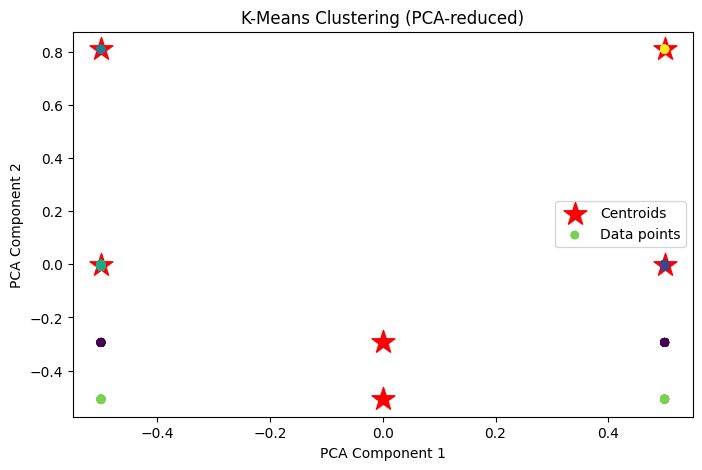

In [290]:
# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_encoded)

# Extract cluster centroids in PCA-reduced space
centers_pca = pca.transform(centers)

# Plot the clusters
plt.figure(figsize=(8, 5))

# Scatter plot of centroids
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], color='red', marker='*', s=300, label='Centroids')

# Scatter plot of the PCA-transformed data points
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=k_means.labels_, cmap='viridis', s=30, label='Data points')

# Labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering (PCA-reduced)')
plt.legend()
plt.show()

In [285]:
score = metrics.silhouette_score (df_encoded, k_means.labels_)
print("Silhouette Score = ", score)

Silhouette Score =  0.44092452723204417


### Cluster: Cantidad_log vs. Donante_Vivo

In [292]:
print(df_donaciones.head())

    Año   Proceso   Órgano    Sexo Grupo_Edad  Cantidad  Donante_Vivo  Cantidad_log
0  2015  Donación    Riñón  Hombre         NA        39             1      3.688879
1  2015  Donación    Riñón   Mujer         NA        32             1      3.496508
2  2015  Donación    Riñón  Hombre         NA        70             0      4.262680
3  2015  Donación    Riñón   Mujer         NA        48             0      3.891820
4  2015  Donación  Corazón  Hombre         NA         0             1      0.000000


In [301]:
df_num = df_donaciones[['Donante_Vivo', 'Cantidad_log', 'Año']]

In [302]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=2, random_state=42)
k_means.fit(df_num)

KMeans(n_clusters=2, random_state=42)

In [303]:
k_means.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [304]:
np.unique(k_means.labels_)

array([0, 1], dtype=int32)

In [305]:
centers = k_means.cluster_centers_
centers

array([[5.00000000e-01, 1.98414580e+00, 2.01778571e+03],
       [5.00000000e-01, 1.77007523e+00, 2.02256000e+03]])

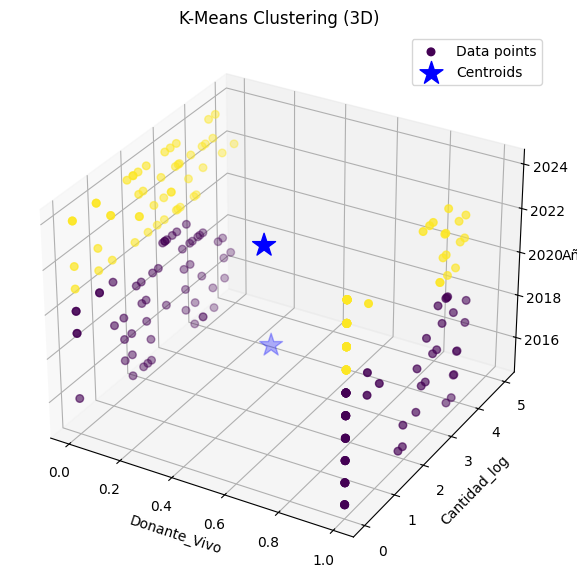

In [307]:
from mpl_toolkits.mplot3d import Axes3D

# Variables a graficar
variables = ['Donante_Vivo', 'Cantidad_log', 'Año']

# Crear figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot: Donante_Vivo vs. Cantidad_log vs. Año
scatter = ax.scatter(
    df_num[variables[0]],  # Eje X
    df_num[variables[1]],  # Eje Y
    df_num[variables[2]],  # Eje Z
    c=k_means.labels_,  # Colores según cluster
    cmap='viridis',
    s=30,
    label='Data points'
)

# Centroides
ax.scatter(
    centers[:, 0],  # Centroide eje X
    centers[:, 1],  # Centroide eje Y
    centers[:, 2],  # Centroide eje Z
    color='blue',
    marker='*',
    s=300,
    label='Centroids'
)

# Etiquetas y título
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
ax.set_title('K-Means Clustering (3D)')
ax.legend()

plt.show()

In [308]:
from sklearn import metrics

score = metrics.silhouette_score (df_num, k_means.labels_)
print("Silhouette Score = ", score)

Silhouette Score =  0.43036929165614946


Text(0.5, 1.0, 'Elbow Plot: Optimal K')

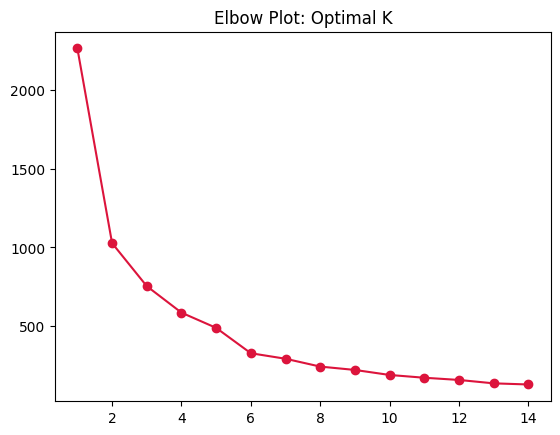

In [309]:
wscc = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, init="k-means++",random_state=0)
    kmeans.fit(df_num)
    wscc.append(kmeans.inertia_)

# Elbowplot: Optimal K
plt.plot(range(1,15),wscc,marker="o",c="crimson")
plt.title("Elbow Plot: Optimal K")

In [310]:
k_means = KMeans(n_clusters=6, random_state=42)
k_means.fit(df_num)

KMeans(n_clusters=6, random_state=42)

In [311]:
np.unique(k_means.labels_)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [312]:
centers = k_means.cluster_centers_
centers

array([[6.85714286e-01, 2.44380921e-01, 2.02005714e+03],
       [3.20000000e-01, 3.22630647e+00, 2.02244000e+03],
       [3.75000000e-01, 3.13469093e+00, 2.01593750e+03],
       [6.84210526e-01, 3.18649482e-01, 2.02321053e+03],
       [7.27272727e-01, 3.12133331e-01, 2.01663636e+03],
       [3.42857143e-01, 3.14507067e+00, 2.01902857e+03]])

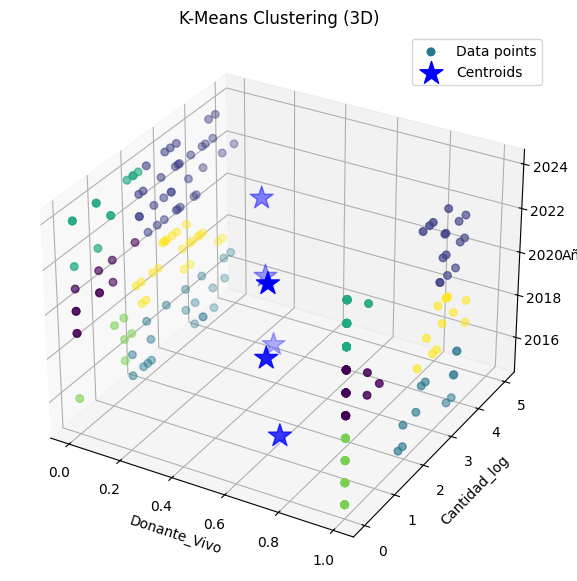

In [313]:
from mpl_toolkits.mplot3d import Axes3D

# Variables a graficar
variables = ['Donante_Vivo', 'Cantidad_log', 'Año']

# Crear figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot: Donante_Vivo vs. Cantidad_log vs. Año
scatter = ax.scatter(
    df_num[variables[0]],  # Eje X
    df_num[variables[1]],  # Eje Y
    df_num[variables[2]],  # Eje Z
    c=k_means.labels_,  # Colores según cluster
    cmap='viridis',
    s=30,
    label='Data points'
)

# Centroides
ax.scatter(
    centers[:, 0],  # Centroide eje X
    centers[:, 1],  # Centroide eje Y
    centers[:, 2],  # Centroide eje Z
    color='blue',
    marker='*',
    s=300,
    label='Centroids'
)

# Etiquetas y título
ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])
ax.set_title('K-Means Clustering (3D)')
ax.legend()

plt.show()

In [ ]:
score = metrics.silhouette_score (df_encoded, k_means.labels_)
print("Silhouette Score = ", score)

Silhouette Score =  0.44092452723204417


## Cantidad log-transform

The `Cantidad` column represent a wide range of numerical values, so we start by doing some **descriptive statistics** to get a better understanding of the data.

In [ ]:
# Statistical description of the Cantidad column
print("Descriptive statistics for Cantidad:")
print(df_trasplantes['Cantidad'].describe())

# Print the Median
print(f"\nMedian: {df_trasplantes['Cantidad'].median()}")

# Calculate the IQR and the limits
q1 = df_trasplantes['Cantidad'].quantile(0.25)
q3 = df_trasplantes['Cantidad'].quantile(0.75)
iqr = q3 - q1

lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

print(f"IQR:{iqr}\nLower limit: {lower_limit}\nUpper limit: {upper_limit}")

Descriptive statistics for Cantidad:
count    1152.000000
mean        9.342014
std        22.703491
min         0.000000
25%         0.000000
50%         1.000000
75%         5.250000
max       203.000000
Name: Cantidad, dtype: float64

Median: 1.0
IQR:5.25
Lower limit: -7.875
Upper limit: 13.125


Some observations:
- The `mean` (_~11_) is significantly lower than the `max` (_203_). This hints that the distribution is **right skewed**.
- Also, the `median` (_1_) is smaller than the `mean` (_11_), further supporting this hypothesis.

With that in mind, we now check the IQR and limits, and their relationship with the actual data:
- First, while the `lower limit` is _-13.5_, the `min` is _0_. Thus, there are **no negative outliers** in the data.
- On the other hand, the `upper limit` is _22.5_, so every value above that should be considered an outlier.

Visualizing the data, we can notice the big tail of the distribution (skewness) in the histogram, and the outliers in the boxplot:

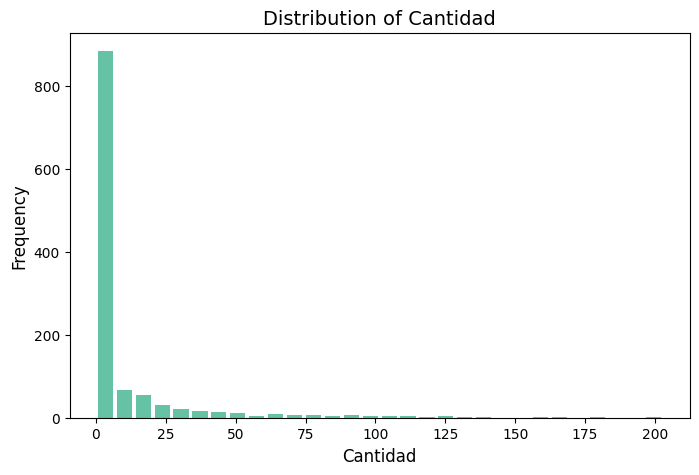

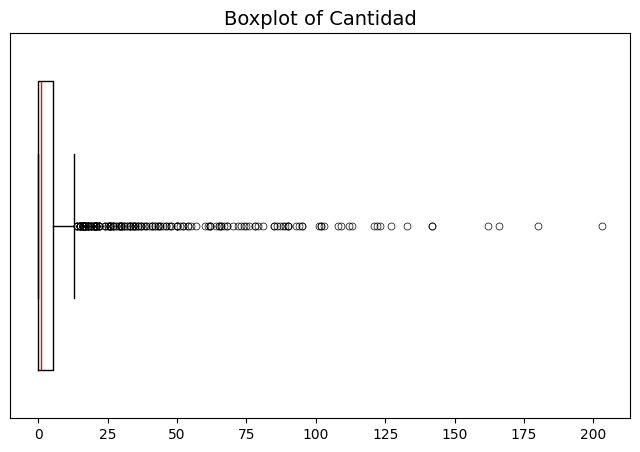

In [ ]:
# Histogram: Cantidad
plt.figure(figsize=(8, 5))
plt.hist(df_trasplantes['Cantidad'], bins=30, rwidth=0.8)
plt.title('Distribution of Cantidad', fontsize=14)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Boxplot: Cantidad
plt.figure(figsize=(8, 5))
medianprops = dict(linestyle='-', color='red')
flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markeredgewidth=0.5)
plt.boxplot(df_trasplantes['Cantidad'], vert=False, medianprops=medianprops, flierprops=flierprops, widths=(0.75))
plt.title('Boxplot of Cantidad', fontsize=14)
plt.yticks([])  # Remove y-axis labels
plt.show()

To address this skewness, we will aply a <span style="color:teal">**log transformation**</span> to the data and then generate the statistical summary and plots again.

<div class="alert alert-block alert-success">
  <span>✅</span> One of the most important advantages of this technique compared to other alternatives (such as <em>min-max</em> or <em>z-score</em>) is the <strong>reduction of the asymmetry</strong> of the distribution, a very valuable point when dealing with extreme outliers that we are not removing.
</div>

Descriptive statistics for Cantidad_log:
count    1152.000000
mean        1.109942
std         1.377216
min         0.000000
25%         0.000000
50%         0.693147
75%         1.830297
max         5.318120
Name: Cantidad_log, dtype: float64

Median: 0.6931471805599453
IQR: 1.8302971391848695
Lower limit: -2.745445708777304
Upper limit: 4.575742847962173



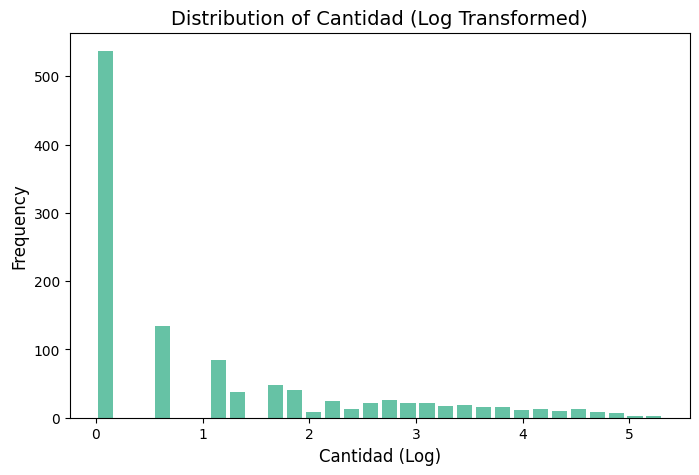

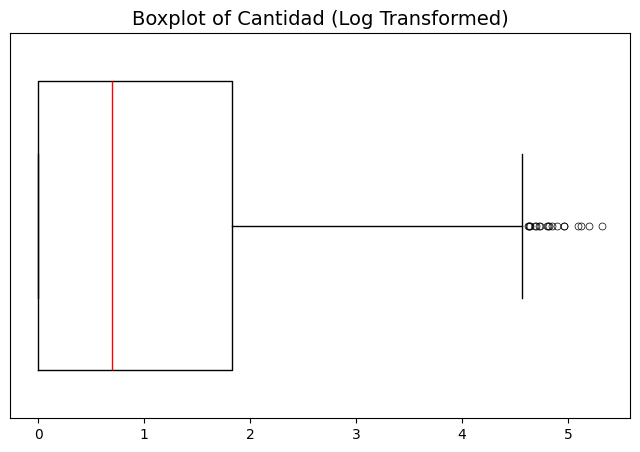

In [ ]:
# Apply log transformation to 'Cantidad'
df_trasplantes.loc[:, 'Cantidad_log'] = np.log1p(df_trasplantes['Cantidad'])  # .loc to get rid of a Warning

# Descriptive statistics
print("Descriptive statistics for Cantidad_log:")
print(df_trasplantes['Cantidad_log'].describe())

# The median
print(f"\nMedian: {df_trasplantes['Cantidad_log'].median()}")

# Calculate the IQR and the limits for the log-transformed column
q1_log = df_trasplantes['Cantidad_log'].quantile(0.25)
q3_log = df_trasplantes['Cantidad_log'].quantile(0.75)
iqr_log = q3_log - q1_log

lower_limit_log = q1_log - 1.5 * iqr_log
upper_limit_log = q3_log + 1.5 * iqr_log

print(f"IQR: {iqr_log}\nLower limit: {lower_limit_log}\nUpper limit: {upper_limit_log}\n")


# Then, we plot again...

# Histogram: Cantidad (log-transformed)
plt.figure(figsize=(8, 5))
plt.hist(df_trasplantes['Cantidad_log'], bins=30, rwidth=0.8)
plt.title('Distribution of Cantidad (Log Transformed)', fontsize=14)
plt.xlabel('Cantidad (Log)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Boxplot: Cantidad (log-transformed)
plt.figure(figsize=(8, 5))
medianprops = dict(linestyle='-', color='red')
flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markeredgewidth=0.5)
plt.boxplot(df_trasplantes['Cantidad_log'], vert=False, medianprops=medianprops, flierprops=flierprops, widths=(0.75))
plt.title('Boxplot of Cantidad (Log Transformed)', fontsize=14)
plt.yticks([])  # Remove y-axis labels
plt.show()

<br/>

# **?. Descriptive Statistics**

With the categorical cleanup finished, we can work on the remaining column: `Cantidad`. As this column represent a wide range of numerical values, we start by doing some **descriptive statistics** to get a better understanding of the data.

In [18]:
# SDtatistical description of the Cantidad column
df['Cantidad'].describe()

,Cantidad
count,2120.000000
mean,19.068396
std,41.635948
min,0.000000
25%,0.000000
50%,2.000000
75%,15.000000
max,283.000000


In [19]:
# Print the Median
print(f"Median: {df['Cantidad'].median()}")

# Calculate the IQR and the limits
q1 = df['Cantidad'].quantile(0.25)
q3 = df['Cantidad'].quantile(0.75)
iqr = q3 - q1

lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

print(f"IQR:{iqr}\nLower limit: {lower_limit}\nUpper limit: {upper_limit}")

Median: 2.0
IQR:15.0
Lower limit: -22.5
Upper limit: 37.5


Some observations:
- The `mean` (_~19_) is significantly lower than the `max` (_283_). This hints that the distribution is **right skewed**.
- Also, the `median` (_2_) is smaller than the `mean` (_19_), further supporting this hypothesis.

With that in mind, we now check the IQR and limits, and their relationship with the actual data:
- First, while the `lower limit` is _-22.5_, the `min` is _0_. Thus, there are **no negative outliers** in the data.
- On the other hand, the `upper limit` is _37.5_, so every value above that should be considered an outlier.

Visualizing the data, we can notice the big tail of the distribution (skewness) in the histogram, and the outliers in the boxplot:

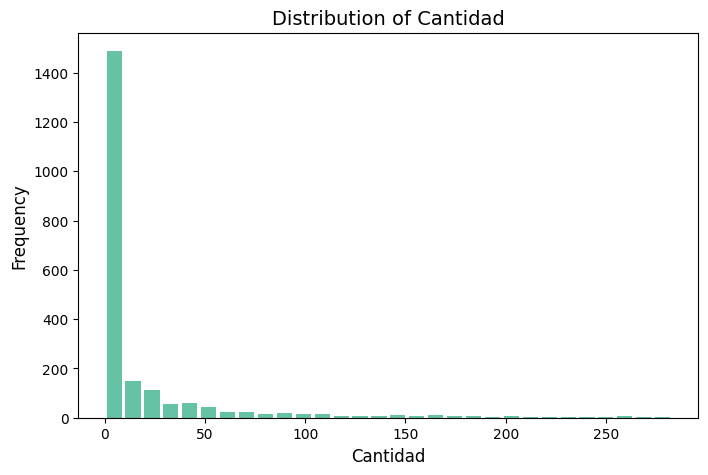

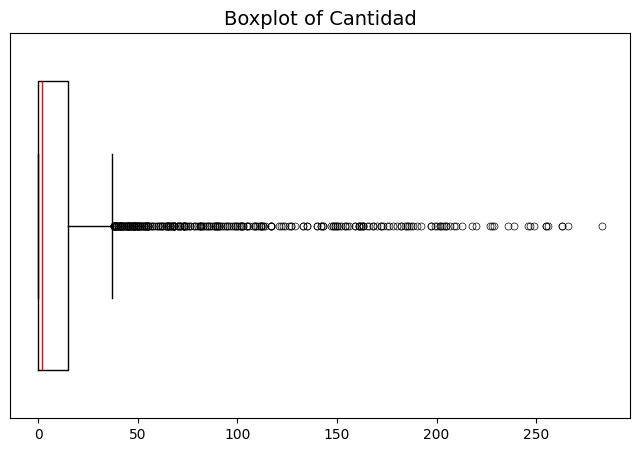

In [20]:
# Paint with custom colors
# colors = plt.colormaps['Set2'].colors
# plt.hist(df['Cantidad'], bins=30, color=colors[0], rwidth=0.8)

# Histogram: Cantidad
plt.figure(figsize=(8, 5))
plt.hist(df['Cantidad'], bins=30, rwidth=0.8)
plt.title('Distribution of Cantidad', fontsize=14)
plt.xlabel('Cantidad', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Boxplot: Cantidad
plt.figure(figsize=(8, 5))
medianprops = dict(linestyle='-', color='red')
flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markeredgewidth=0.5)
plt.boxplot(df['Cantidad'], vert=False, medianprops=medianprops, flierprops=flierprops, widths=(0.75))
plt.title('Boxplot of Cantidad', fontsize=14)
plt.yticks([])  # Remove y-axis labels
plt.show()

In [21]:
# Inspeccionar los posibles outliers
# outliers = df[df['Cantidad'] > upper_limit]
# print(outliers)

# Trasplantes 2015
print("Trasplantes 2015")
outliers = df[(df['Proceso'] == "Trasplante") & (df['Año'] == 2015) & (df['Órgano'] == "Riñón") & (df['Sexo'] == "Hombre")]
print(outliers)

print("\n----------------------------\n")

# Donaciones 2015 (Total: 309)
print("Lista de Espera 2015")
outliers = df[(df['Proceso'] == "Lista de Espera") & (df['Año'] == 2015) & (df['Órgano'] == "Riñón") & (df['Sexo'] == "Hombre")]
print(outliers)

print("\n----------------------------\n")

# "Donación Personas" 2015 (81 Vivo, 152 Cadavérico)
print("Donación Personas 2015")
outliers = df[(df['Proceso'] == "Donación Personas") & (df['Año'] == 2015) & (df['Tipo de donante'] == "Vivo")]
print(outliers)

print("\n----------------------------\n")

# Contar cuántos registros hay para cada valor de 'Proceso'
proceso_counts = df['Proceso'].value_counts()
print(proceso_counts)

Trasplantes 2015
      Año     Proceso Órgano    Sexo Grupo de edad  Cantidad Tipo de donante
864  2015  Trasplante  Riñón  Hombre      0-9 Años         4       No Aplica
865  2015  Trasplante  Riñón  Hombre    10-19 Años        12       No Aplica
866  2015  Trasplante  Riñón  Hombre    20-29 Años        16       No Aplica
867  2015  Trasplante  Riñón  Hombre    30-39 Años        30       No Aplica
868  2015  Trasplante  Riñón  Hombre    40-49 Años        26       No Aplica
869  2015  Trasplante  Riñón  Hombre    50-59 Años        41       No Aplica
870  2015  Trasplante  Riñón  Hombre    60-69 Años        36       No Aplica
871  2015  Trasplante  Riñón  Hombre     > 70 Años         2       No Aplica

----------------------------

Lista de Espera 2015
      Año          Proceso Órgano    Sexo Grupo de edad  Cantidad Tipo de donante
160  2015  Lista de Espera  Riñón  Hombre      0-9 Años         3       No Aplica
161  2015  Lista de Espera  Riñón  Hombre    10-19 Años        17       No

<br/>
<br/>
<br/>
<br/>
<br/>

# **x. Exhibits**

Additional tools that come in handy for the project execution.

## x.1 - Python _requirements.txt_ utilities

In [22]:
# Create requirements.txt file
# !pip freeze > requirements.txt

# Install requirements.txt
# !pip install -r requirements.txt